In [1]:
import os
import torch
import torchvision
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from torchvision import transforms, datasets
from torchinfo import summary
from torch.utils.data import DataLoader
from torch import nn
from helperfunctions import walk_through_dir, pred_and_plot_image, save_model 
from model_train import train
from sklearn.metrics import confusion_matrix 
from typing import Tuple, Dict, List

In [37]:
def plot_loss_curves(results: Dict[str, List[float]], name):
    """Plots training curves of rsults dictionary"""
    loss = results["train_loss"]
    test_loss= results["test_loss"]
    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]
    epochs = range(len(results["train_loss"]))
    plt.figure(figsize=(15,7))
    plt.subplot(1,2,1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss" if name == "test" else "val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend();
    plt.subplot(1,2,2)
    plt.plot(epochs, accuracy, label="train_acc")
    plt.plot(epochs, test_accuracy, label="test_acc" if name == "test" else "val_acc")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend();

In [38]:
def set_seed():
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)

In [39]:
def plot_confusion_matrix(model, dataloader, device):
    all_preds = []
    all_labels = []
    correct = 0
    total = 0
    model.eval() 
    with torch.inference_mode():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    print(f'Test Accuracy: {test_accuracy:.2f}%')
    # Compute the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot the confusion matrix using seaborn
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [40]:
device = "cuda" if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [41]:
data_path = Path("./data/")
image_path = data_path / "CT-KIDNEY"
image_path = data_path / "CT-KIDNEY-VAL"
train_dir = image_path / "train"
test_dir = image_path / "test"
val_dir = image_path / "val"
walk_through_dir(image_path)

There are 3 directories and 0 images in data\CT-KIDNEY-VAL
There are 4 directories and 0 images in data\CT-KIDNEY-VAL\test
There are 0 directories and 372 images in data\CT-KIDNEY-VAL\test\Cyst
There are 0 directories and 509 images in data\CT-KIDNEY-VAL\test\Normal
There are 0 directories and 139 images in data\CT-KIDNEY-VAL\test\Stone
There are 0 directories and 229 images in data\CT-KIDNEY-VAL\test\Tumor
There are 4 directories and 0 images in data\CT-KIDNEY-VAL\train
There are 0 directories and 2967 images in data\CT-KIDNEY-VAL\train\Cyst
There are 0 directories and 4061 images in data\CT-KIDNEY-VAL\train\Normal
There are 0 directories and 1101 images in data\CT-KIDNEY-VAL\train\Stone
There are 0 directories and 1826 images in data\CT-KIDNEY-VAL\train\Tumor
There are 4 directories and 0 images in data\CT-KIDNEY-VAL\val
There are 0 directories and 370 images in data\CT-KIDNEY-VAL\val\Cyst
There are 0 directories and 507 images in data\CT-KIDNEY-VAL\val\Normal
There are 0 directories

In [42]:
vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
vit_transforms = vit_weights.transforms()
BATCH_SIZE =32

# Image folders
train_data = datasets.ImageFolder(root= train_dir, 
                                transform= vit_transforms)
test_data = datasets.ImageFolder(root=test_dir, 
                                transform=vit_transforms)
val_data = datasets.ImageFolder(root=val_dir, 
                                transform=vit_transforms)
# Data Loaders
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=False)
val_dataloader = DataLoader(dataset=val_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=False)

In [43]:
class_names = train_data.classes
class_names

['Cyst', 'Normal', 'Stone', 'Tumor']

## VIT 

### case 1: last layer only trainable and learning rate 1e-3

In [9]:
vit_1e_3 = torchvision.models.vit_b_16(weights=vit_weights).to(device)
for parameter in vit_1e_3.parameters():
    parameter.requires_grad=False
torch.manual_seed(42)
torch.cuda.manual_seed(42)
vit_1e_3.heads = nn.Linear(in_features=768,
                            out_features=len(class_names)).to(device)
summary(model=vit_1e_3,
        input_size=(1, 3, 224, 224), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

c:\Users\Thoyajaksha Kashyap\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\activation.py:1221: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  return torch._native_multi_head_attention(


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 4]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [10]:
# Setup optimizer and loss functions
optimizer = torch.optim.Adam(params=vit_1e_3.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

In [11]:
# Train the model
set_seed()
vit_1e_3_results = train(model=vit_1e_3,
                    train_dataloader=train_dataloader,
                    test_dataloader=val_dataloader,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    epochs=10,
                    device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 0.4573 , Train acc: 0.8584 | Test loss: 0.2847, Test acc: 0.9173
Epoch: 1 | Train loss: 0.2109 , Train acc: 0.9434 | Test loss: 0.1910, Test acc: 0.9470
Epoch: 2 | Train loss: 0.1490 , Train acc: 0.9630 | Test loss: 0.1460, Test acc: 0.9638
Epoch: 3 | Train loss: 0.1172 , Train acc: 0.9736 | Test loss: 0.1167, Test acc: 0.9694
Epoch: 4 | Train loss: 0.0947 , Train acc: 0.9801 | Test loss: 0.1001, Test acc: 0.9718
Epoch: 5 | Train loss: 0.0807 , Train acc: 0.9844 | Test loss: 0.0847, Test acc: 0.9804
Epoch: 6 | Train loss: 0.0682 , Train acc: 0.9882 | Test loss: 0.0745, Test acc: 0.9820
Epoch: 7 | Train loss: 0.0594 , Train acc: 0.9904 | Test loss: 0.0637, Test acc: 0.9842
Epoch: 8 | Train loss: 0.0510 , Train acc: 0.9925 | Test loss: 0.0556, Test acc: 0.9876
Epoch: 9 | Train loss: 0.0470 , Train acc: 0.9924 | Test loss: 0.0523, Test acc: 0.9944


Test Accuracy: 99.60%


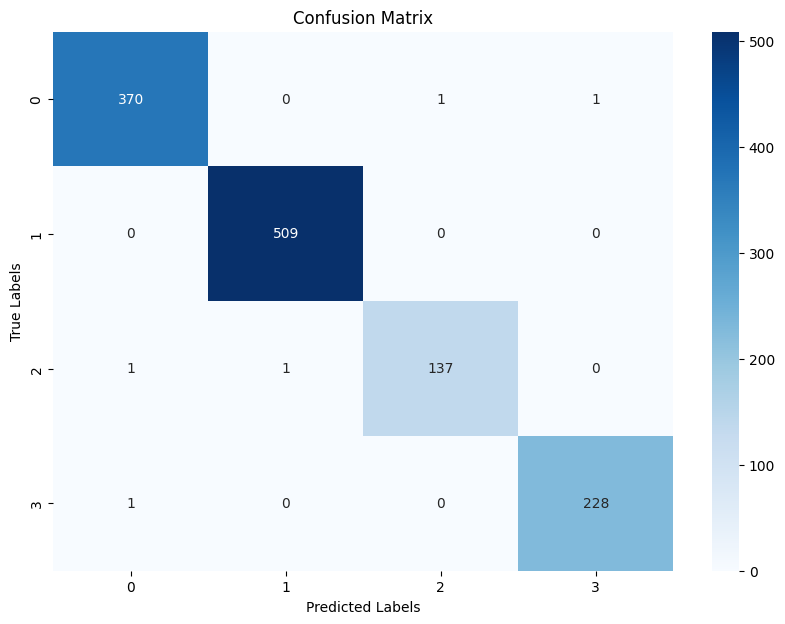

In [12]:
# Plots the confusion matrix
plot_confusion_matrix(vit_1e_3, test_dataloader, device)

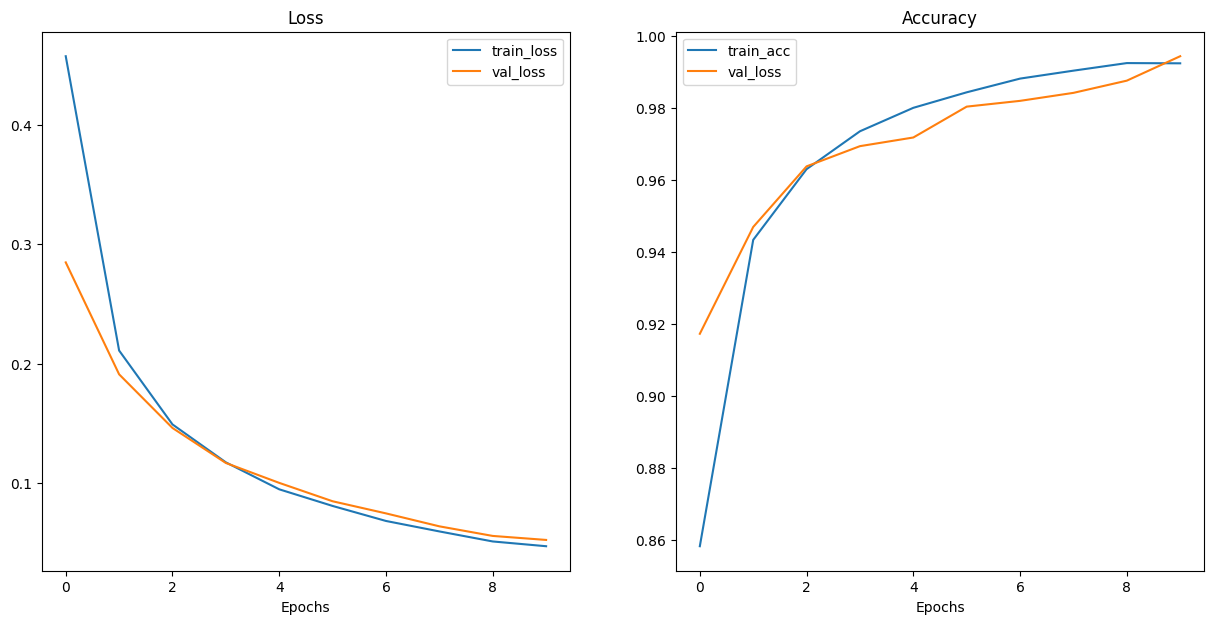

In [13]:
# Plots the loss and accuracy curves
plot_loss_curves(vit_1e_3_results, "val")

In [14]:
# Save the model
save_model(vit_1e_3, "models", "vit_1e-3.pth")

[INFO] Saving model to: models\vit_1e-3.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


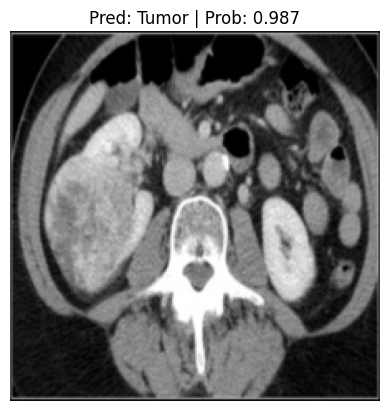

In [15]:
# Custom Image
custom_image_path = data_path / "Tumor1.jpg"
custom_transform = transforms.Compose([
    transforms.Resize((224, 224))
])
pred_and_plot_image(model=vit_1e_3,
                    image_path=custom_image_path,
                    transform = custom_transform,
                    class_names=class_names)

### case 2: last layer only trainable and learning rate 1e-2

In [16]:
vit_1e_2 = torchvision.models.vit_b_16(weights=vit_weights).to(device)
for parameter in vit_1e_2.parameters():
    parameter.requires_grad=False
torch.manual_seed(42)
torch.cuda.manual_seed(42)
vit_1e_2.heads = nn.Linear(in_features=768,
                                 out_features=len(class_names)).to(device)
summary(model=vit_1e_2,
        input_size=(1, 3, 224, 224), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 4]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [17]:
# Setup optimizer and loss functions
optimizer = torch.optim.Adam(params=vit_1e_2.parameters(),
                             lr=1e-2)
loss_fn = torch.nn.CrossEntropyLoss()

In [18]:
# Train the model
set_seed()
vit_1e_2_results = train(model=vit_1e_2,
                    train_dataloader=train_dataloader,
                    test_dataloader=val_dataloader,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    epochs=10,
                    device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 0.2442 , Train acc: 0.9100 | Test loss: 0.1091, Test acc: 0.9577
Epoch: 1 | Train loss: 0.0772 , Train acc: 0.9735 | Test loss: 0.0471, Test acc: 0.9854
Epoch: 2 | Train loss: 0.0452 , Train acc: 0.9851 | Test loss: 0.0323, Test acc: 0.9910
Epoch: 3 | Train loss: 0.0376 , Train acc: 0.9879 | Test loss: 0.0995, Test acc: 0.9616
Epoch: 4 | Train loss: 0.0315 , Train acc: 0.9899 | Test loss: 0.0589, Test acc: 0.9744
Epoch: 5 | Train loss: 0.0361 , Train acc: 0.9870 | Test loss: 0.0135, Test acc: 0.9960
Epoch: 6 | Train loss: 0.0136 , Train acc: 0.9967 | Test loss: 0.0219, Test acc: 0.9928
Epoch: 7 | Train loss: 0.0182 , Train acc: 0.9945 | Test loss: 0.0243, Test acc: 0.9910
Epoch: 8 | Train loss: 0.0100 , Train acc: 0.9972 | Test loss: 0.0191, Test acc: 0.9924
Epoch: 9 | Train loss: 0.0106 , Train acc: 0.9968 | Test loss: 0.1173, Test acc: 0.9630


Test Accuracy: 96.64%


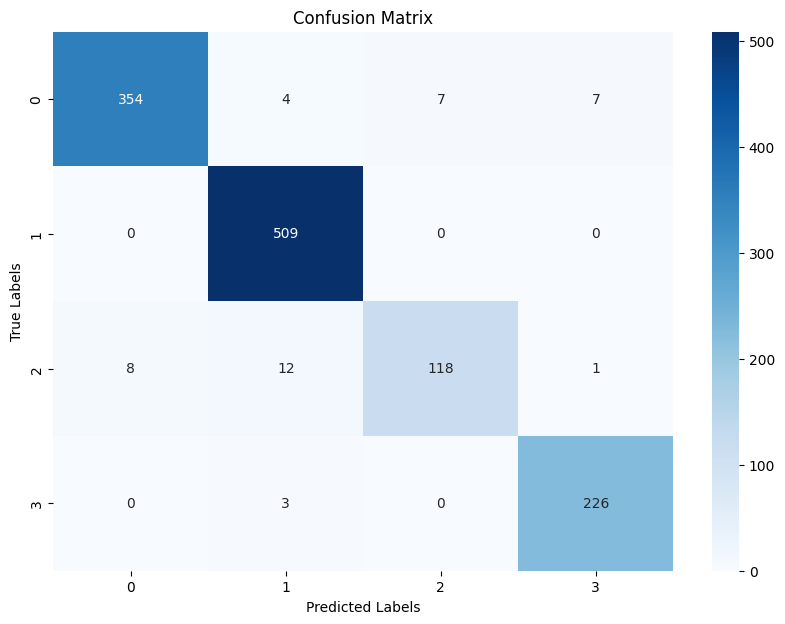

In [19]:
# Plots the confusion matrix
plot_confusion_matrix(vit_1e_2, test_dataloader, device)

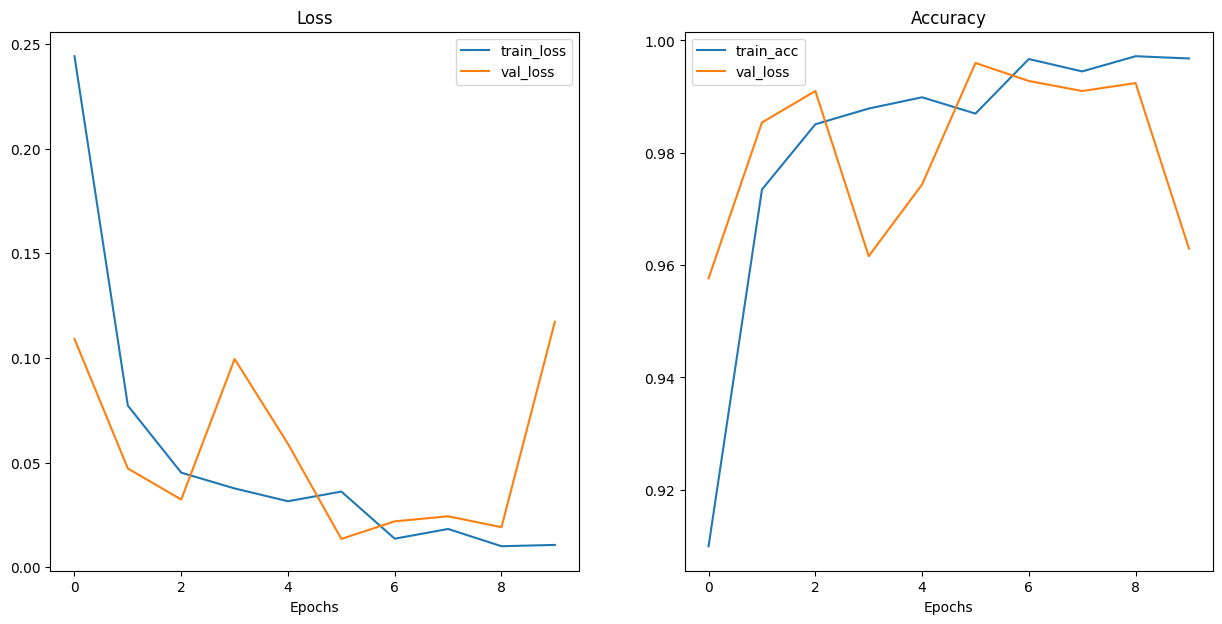

In [20]:
# Plots the loss and accuracy curves
plot_loss_curves(vit_1e_2_results, "val")

In [21]:
# Save the model
save_model(vit_1e_2, "models", "vit_1e-2.pth")

[INFO] Saving model to: models\vit_1e-2.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


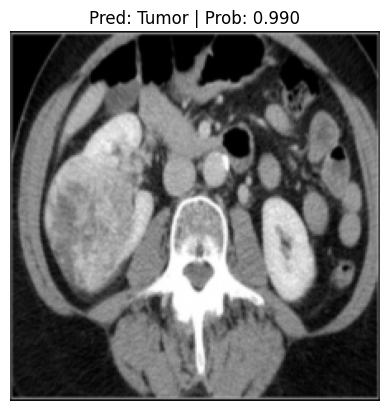

In [22]:
# Custom Image
custom_image_path = data_path / "Tumor1.jpg"
custom_transform = transforms.Compose([
    transforms.Resize((224, 224))
])
pred_and_plot_image(model=vit_1e_2,
                    image_path=custom_image_path,
                    transform=custom_transform,
                    class_names=class_names)

### case 3: last layer only trainable and learning rate 1e-4

In [23]:
vit_1e_4 = torchvision.models.vit_b_16(weights=vit_weights).to(device)
for parameter in vit_1e_4.parameters():
    parameter.requires_grad=False
torch.manual_seed(42)
torch.cuda.manual_seed(42)
vit_1e_4.heads = nn.Linear(in_features=768,
                                 out_features=len(class_names)).to(device)
summary(model=vit_1e_4,
        input_size=(1, 3, 224, 224), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 4]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [24]:
# Setup optimizer and loss functions
optimizer = torch.optim.Adam(params=vit_1e_4.parameters(),
                             lr=1e-4)
loss_fn = torch.nn.CrossEntropyLoss()

In [25]:
# Train the model
set_seed()
vit_1e_4_results = train(model=vit_1e_4,
                    train_dataloader=train_dataloader,
                    test_dataloader=val_dataloader,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    epochs=10,
                    device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 0.9649 , Train acc: 0.6749 | Test loss: 0.7776, Test acc: 0.7710
Epoch: 1 | Train loss: 0.6513 , Train acc: 0.8033 | Test loss: 0.5972, Test acc: 0.8211
Epoch: 2 | Train loss: 0.5182 , Train acc: 0.8509 | Test loss: 0.4990, Test acc: 0.8571
Epoch: 3 | Train loss: 0.4395 , Train acc: 0.8812 | Test loss: 0.4340, Test acc: 0.8883
Epoch: 4 | Train loss: 0.3843 , Train acc: 0.8973 | Test loss: 0.3887, Test acc: 0.8968
Epoch: 5 | Train loss: 0.3443 , Train acc: 0.9089 | Test loss: 0.3543, Test acc: 0.9083
Epoch: 6 | Train loss: 0.3149 , Train acc: 0.9163 | Test loss: 0.3255, Test acc: 0.9130
Epoch: 7 | Train loss: 0.2890 , Train acc: 0.9241 | Test loss: 0.3023, Test acc: 0.9194
Epoch: 8 | Train loss: 0.2667 , Train acc: 0.9293 | Test loss: 0.2826, Test acc: 0.9258
Epoch: 9 | Train loss: 0.2501 , Train acc: 0.9342 | Test loss: 0.2656, Test acc: 0.9308


Test Accuracy: 93.35%


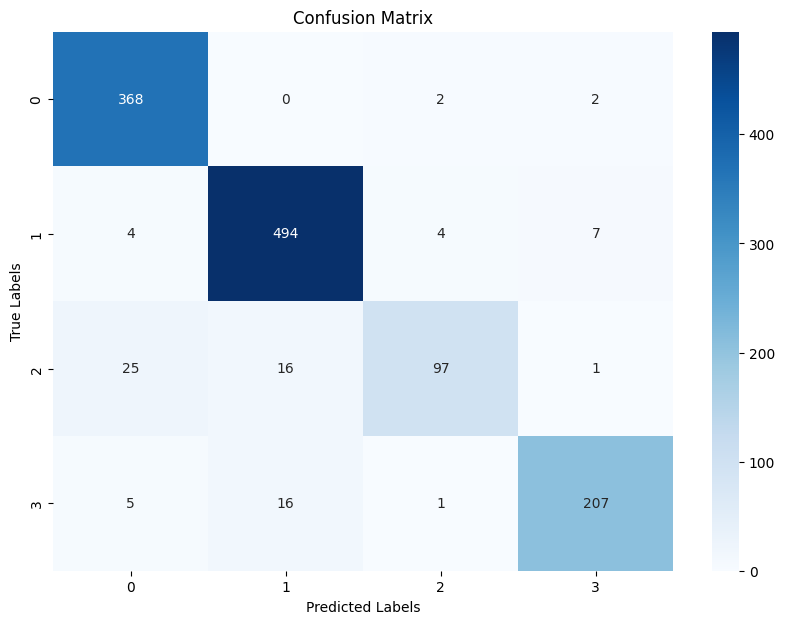

In [26]:
# Plots the confusion matrix
plot_confusion_matrix(vit_1e_4, test_dataloader, device)

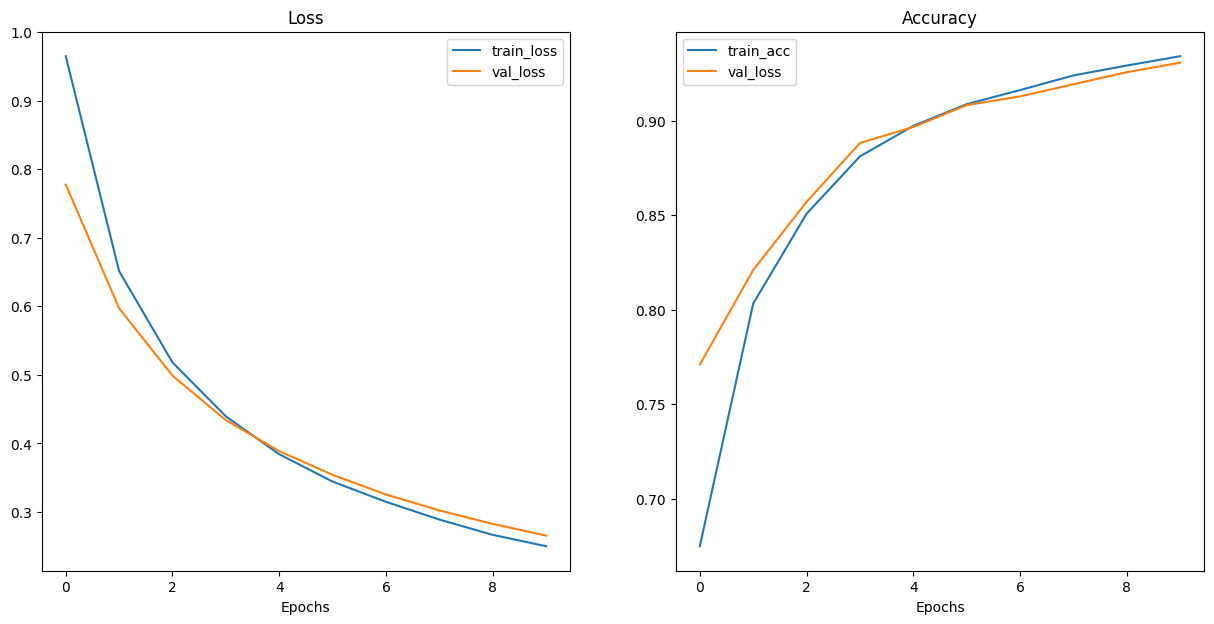

In [27]:
# Plots the loss and accuracy curves
plot_loss_curves(vit_1e_4_results, "val")

In [28]:
# Save the model
save_model(vit_1e_4, "models", "vit_1e-4.pth")

[INFO] Saving model to: models\vit_1e-4.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


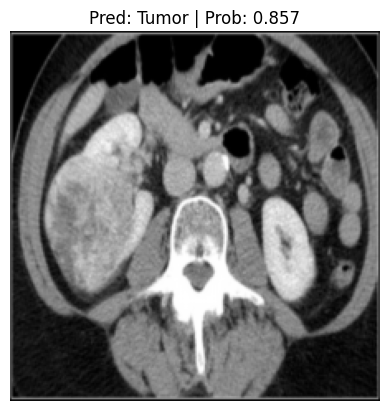

In [48]:
# Custom Image
custom_image_path = data_path / "Tumor1.jpg"
custom_transform = transforms.Compose([
    transforms.Resize((224, 224))
])
pred_and_plot_image(model=vit_1e_4,
                    image_path=custom_image_path,
                    transform=custom_transform,
                    class_names=class_names)

### case 4: last layer only trainable and learning rate 0.5

In [29]:
vit_0_5 = torchvision.models.vit_b_16(weights=vit_weights).to(device)
for parameter in vit_0_5.parameters():
    parameter.requires_grad=False
torch.manual_seed(42)
torch.cuda.manual_seed(42)
vit_0_5.heads = nn.Linear(in_features=768,
                                 out_features=len(class_names)).to(device)
summary(model=vit_0_5,
        input_size=(1, 3, 224, 224), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 4]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [30]:
# Setup optimizer and loss functions
optimizer = torch.optim.Adam(params=vit_0_5.parameters(),
                             lr=0.5)
loss_fn = torch.nn.CrossEntropyLoss()

In [31]:
# Train the model
set_seed()
vit_0_5_results = train(model=vit_0_5,
                    train_dataloader=train_dataloader,
                    test_dataloader=val_dataloader,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    epochs=10,
                    device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 7.5512 , Train acc: 0.8773 | Test loss: 1.8777, Test acc: 0.9548
Epoch: 1 | Train loss: 3.2008 , Train acc: 0.9428 | Test loss: 1.6970, Test acc: 0.9528
Epoch: 2 | Train loss: 2.7650 , Train acc: 0.9581 | Test loss: 3.3319, Test acc: 0.9581
Epoch: 3 | Train loss: 2.5042 , Train acc: 0.9620 | Test loss: 4.6525, Test acc: 0.9495
Epoch: 4 | Train loss: 2.0999 , Train acc: 0.9716 | Test loss: 4.7244, Test acc: 0.9393
Epoch: 5 | Train loss: 2.0469 , Train acc: 0.9749 | Test loss: 1.0396, Test acc: 0.9816
Epoch: 6 | Train loss: 1.4859 , Train acc: 0.9798 | Test loss: 2.3840, Test acc: 0.9706
Epoch: 7 | Train loss: 1.8278 , Train acc: 0.9782 | Test loss: 1.9405, Test acc: 0.9740
Epoch: 8 | Train loss: 1.4707 , Train acc: 0.9810 | Test loss: 0.6812, Test acc: 0.9894
Epoch: 9 | Train loss: 1.2555 , Train acc: 0.9834 | Test loss: 5.8310, Test acc: 0.9519


Test Accuracy: 95.44%


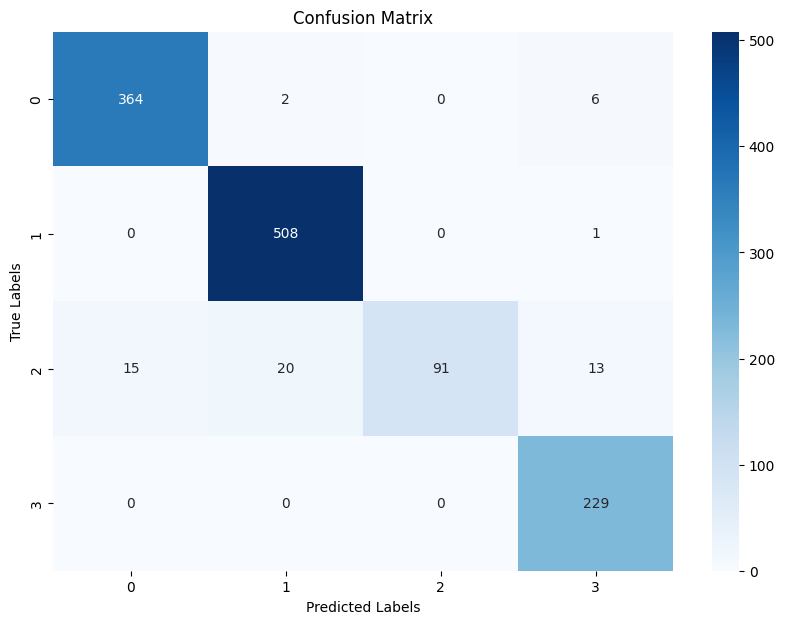

In [32]:
# Plots the confusion matrix
plot_confusion_matrix(vit_0_5, test_dataloader, device)

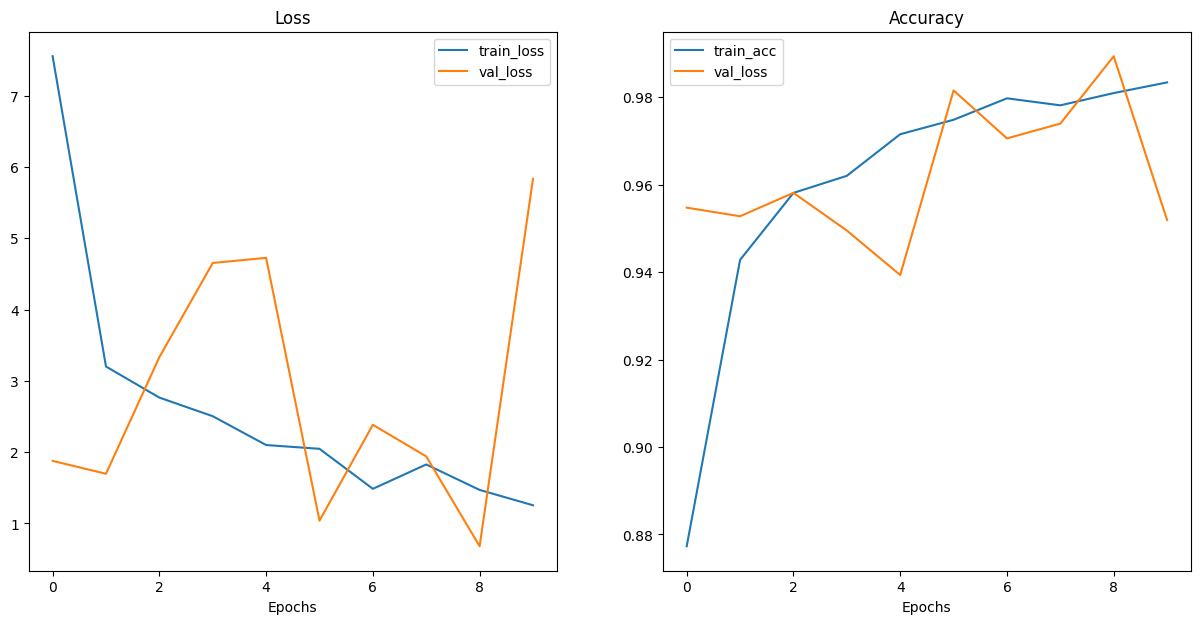

In [33]:
# Plots the loss and accuracy curves
plot_loss_curves(vit_0_5_results, "val")

In [34]:
# Save the model
save_model(vit_0_5, "models", "vit_0_5.pth")

[INFO] Saving model to: models\vit_0_5.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


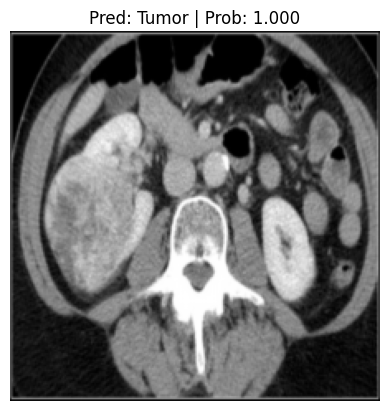

In [49]:
# Custom Image
custom_image_path = data_path / "Tumor1.jpg"
custom_transform = transforms.Compose([
    transforms.Resize((224, 224))
])
pred_and_plot_image(model=vit_0_5,
                    image_path=custom_image_path,
                    transform=custom_transform,
                    class_names=class_names)

### case 5: Freeze till 4 layers and learning rate 1e-3

In [35]:
vit_freeze_till_4 = torchvision.models.vit_b_16(weights=vit_weights).to(device)
for name, param in vit_freeze_till_4.named_parameters():
    if 'encoder.layers.encoder_layer_' in name:
        layer_number = int(name.split('.')[2].split('_')[-1])
        if layer_number <= 4:
            param.requires_grad = False  
        else:
            param.requires_grad = True   
    else:
        param.requires_grad = True 

vit_freeze_till_4.heads = nn.Linear(in_features=768,
                                 out_features=len(class_names)).to(device)

summary(model=vit_freeze_till_4,
        input_size=(1, 3, 224, 224), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 4]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              Partial
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   Partial
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1

In [36]:
optimizer = torch.optim.Adam(vit_freeze_till_4.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

In [38]:
set_seed()
vit_results_freeze_till_4 = train(model=vit_freeze_till_4,
                                train_dataloader=train_dataloader,
                                test_dataloader=val_dataloader,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                epochs=10,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 0.4764 , Train acc: 0.8238 | Test loss: 0.4019, Test acc: 0.8488
Epoch: 1 | Train loss: 0.3789 , Train acc: 0.8622 | Test loss: 0.3680, Test acc: 0.8730
Epoch: 2 | Train loss: 0.2799 , Train acc: 0.8999 | Test loss: 0.2698, Test acc: 0.9005
Epoch: 3 | Train loss: 0.2161 , Train acc: 0.9238 | Test loss: 0.2122, Test acc: 0.9215
Epoch: 4 | Train loss: 0.1455 , Train acc: 0.9490 | Test loss: 0.1310, Test acc: 0.9504
Epoch: 5 | Train loss: 0.1090 , Train acc: 0.9628 | Test loss: 0.1405, Test acc: 0.9429
Epoch: 6 | Train loss: 0.1320 , Train acc: 0.9514 | Test loss: 0.1211, Test acc: 0.9583
Epoch: 7 | Train loss: 0.1066 , Train acc: 0.9619 | Test loss: 0.0786, Test acc: 0.9722
Epoch: 8 | Train loss: 0.1014 , Train acc: 0.9646 | Test loss: 0.1442, Test acc: 0.9534
Epoch: 9 | Train loss: 0.1248 , Train acc: 0.9572 | Test loss: 0.1132, Test acc: 0.9599


Test Accuracy: 95.68%


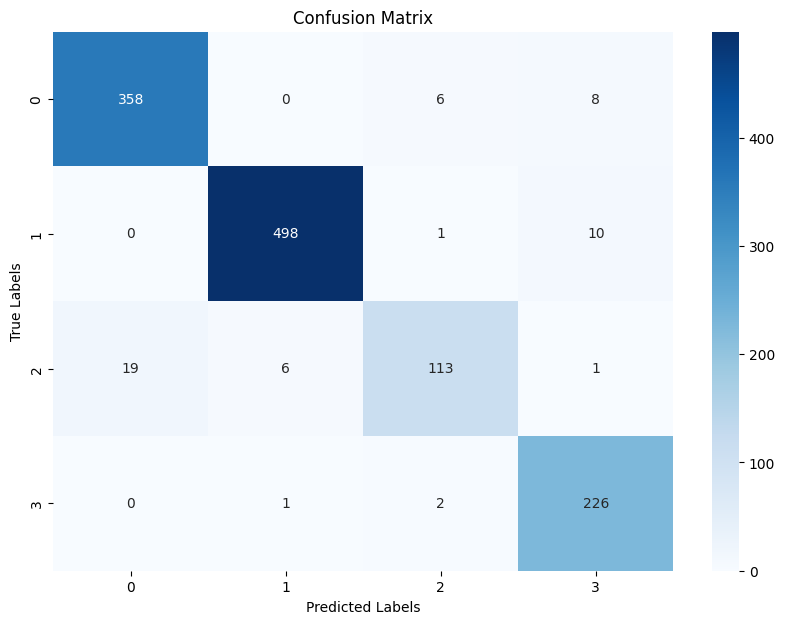

In [39]:
# Plots the confusion matrix
plot_confusion_matrix(vit_freeze_till_4, test_dataloader, device)

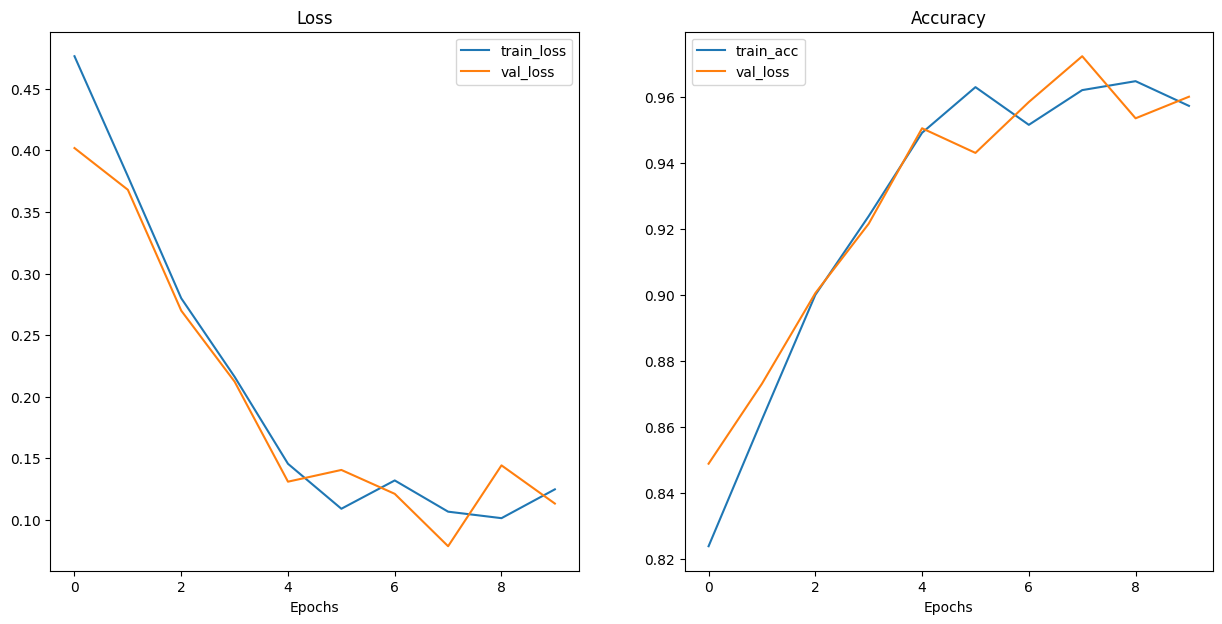

In [40]:
# Plots the loss and accuracy curves
plot_loss_curves(vit_results_freeze_till_4, "val")

In [41]:
# Save the model
save_model(vit_freeze_till_4, "models", "vit_freeze_till_4.pth")

[INFO] Saving model to: models\vit_freeze_till_4.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


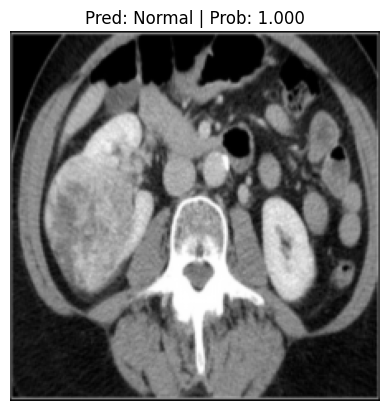

In [50]:
# Custom Image
custom_image_path = data_path / "Tumor1.jpg"
custom_transform = transforms.Compose([
    transforms.Resize((224, 224))
])
pred_and_plot_image(model=vit_freeze_till_4,
                    image_path=custom_image_path,
                    transform=custom_transform,
                    class_names=class_names)

### case 6: Freeze till 6 layers and learning rate 1e-3

In [42]:
vit_freeze_till_6 = torchvision.models.vit_b_16(weights=vit_weights).to(device)
for name, param in vit_freeze_till_6.named_parameters():
    if 'encoder.layers.encoder_layer_' in name:
        layer_number = int(name.split('.')[2].split('_')[-1])
        if layer_number <= 6:
            param.requires_grad = False  
        else:
            param.requires_grad = True   
    else:
        param.requires_grad = True 
vit_freeze_till_6.heads = nn.Linear(in_features=768,
                                 out_features=len(class_names)).to(device)
summary(model=vit_freeze_till_6,
        input_size=(1, 3, 224, 224), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 4]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              Partial
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   Partial
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1

In [43]:
optimizer = torch.optim.Adam(vit_freeze_till_6.parameters(), 
                             lr=1e-3)  
loss_fn = torch.nn.CrossEntropyLoss()

In [44]:
set_seed()
vit_results_freeze_till_6 = train(model=vit_freeze_till_6,
                                train_dataloader=train_dataloader,
                                test_dataloader=val_dataloader,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                epochs=10,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 0.8720 , Train acc: 0.6683 | Test loss: 0.7980, Test acc: 0.6824
Epoch: 1 | Train loss: 0.6551 , Train acc: 0.7530 | Test loss: 0.5388, Test acc: 0.7930
Epoch: 2 | Train loss: 0.4715 , Train acc: 0.8211 | Test loss: 0.3621, Test acc: 0.8674
Epoch: 3 | Train loss: 0.3697 , Train acc: 0.8649 | Test loss: 0.3363, Test acc: 0.8830
Epoch: 4 | Train loss: 0.4211 , Train acc: 0.8444 | Test loss: 0.3137, Test acc: 0.8886
Epoch: 5 | Train loss: 0.2510 , Train acc: 0.9119 | Test loss: 0.2546, Test acc: 0.9009
Epoch: 6 | Train loss: 0.3441 , Train acc: 0.8751 | Test loss: 0.2571, Test acc: 0.9071
Epoch: 7 | Train loss: 0.2570 , Train acc: 0.9097 | Test loss: 0.6316, Test acc: 0.8101
Epoch: 8 | Train loss: 0.2295 , Train acc: 0.9174 | Test loss: 0.2443, Test acc: 0.9156
Epoch: 9 | Train loss: 0.1681 , Train acc: 0.9402 | Test loss: 0.2547, Test acc: 0.9090


Test Accuracy: 95.68%


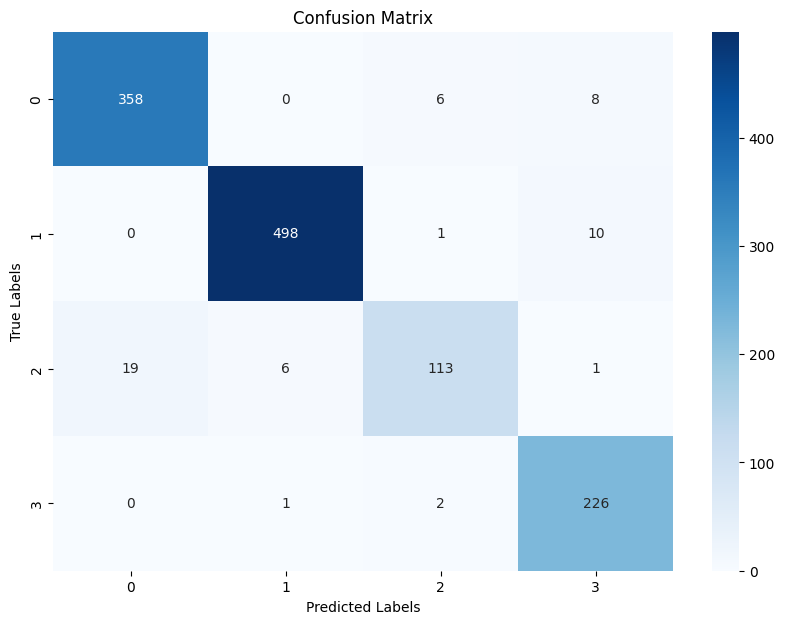

In [45]:
# Plots the confusion matrix
plot_confusion_matrix(vit_freeze_till_4, test_dataloader, device)

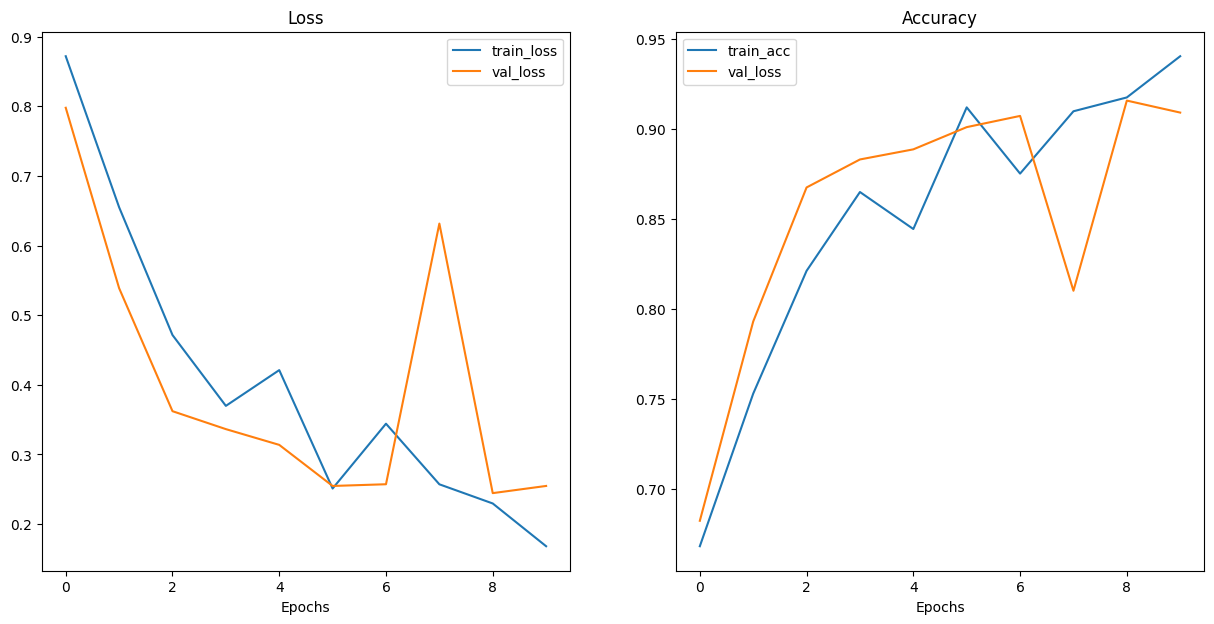

In [46]:
# Plots the loss and accuracy curves
plot_loss_curves(vit_results_freeze_till_6, "val")

In [47]:
# Save the model
save_model(vit_freeze_till_6, "models", "vit_freeze_till_6.pth")

[INFO] Saving model to: models\vit_freeze_till_6.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


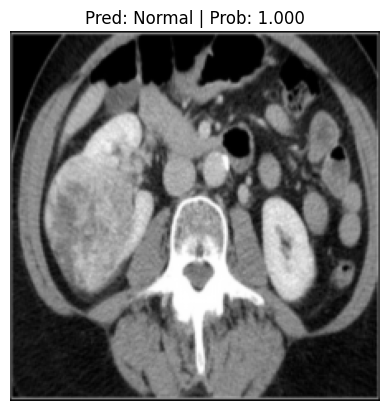

In [51]:
# Custom Image
custom_image_path = data_path / "Tumor1.jpg"
custom_transform = transforms.Compose([
    transforms.Resize((224, 224))
])
pred_and_plot_image(model=vit_freeze_till_6,
                    image_path=custom_image_path,
                    transform=custom_transform,
                    class_names=class_names)

### case 7 Add a dropout in the head 

In [53]:
vit_1e_3_dropout = torchvision.models.vit_b_16(weights=vit_weights).to(device)
for parameter in vit_1e_3_dropout.parameters():
    parameter.requires_grad=False
torch.manual_seed(42)
torch.cuda.manual_seed(42)
vit_1e_3_dropout.heads = nn.Sequential(
    nn.Dropout(0.5), 
    nn.Linear(in_features=768,
              out_features=len(class_names)).to(device)
)
summary(model=vit_1e_3_dropout,
        input_size=(1, 3, 224, 224), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 4]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [55]:
# Setup optimizer and loss functions
optimizer = torch.optim.Adam(params=vit_1e_3_dropout.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

In [56]:
# Train the model
set_seed()
vit_1e_3_dropout_results = train(model=vit_1e_3_dropout,
                    train_dataloader=train_dataloader,
                    test_dataloader=val_dataloader,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    epochs=10,
                    device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.4487 , Train acc: 0.2932 | Test loss: 1.3931, Test acc: 0.2986
Epoch: 1 | Train loss: 1.4538 , Train acc: 0.2926 | Test loss: 1.3931, Test acc: 0.2986
Epoch: 2 | Train loss: 1.4479 , Train acc: 0.2928 | Test loss: 1.3931, Test acc: 0.2986
Epoch: 3 | Train loss: 1.4594 , Train acc: 0.2830 | Test loss: 1.3931, Test acc: 0.2986
Epoch: 4 | Train loss: 1.4521 , Train acc: 0.2896 | Test loss: 1.3931, Test acc: 0.2986
Epoch: 5 | Train loss: 1.4505 , Train acc: 0.2930 | Test loss: 1.3931, Test acc: 0.2986
Epoch: 6 | Train loss: 1.4470 , Train acc: 0.2887 | Test loss: 1.3931, Test acc: 0.2986
Epoch: 7 | Train loss: 1.4477 , Train acc: 0.2926 | Test loss: 1.3931, Test acc: 0.2986
Epoch: 8 | Train loss: 1.4448 , Train acc: 0.2987 | Test loss: 1.3931, Test acc: 0.2986
Epoch: 9 | Train loss: 1.4477 , Train acc: 0.2929 | Test loss: 1.3931, Test acc: 0.2986


Test Accuracy: 30.18%


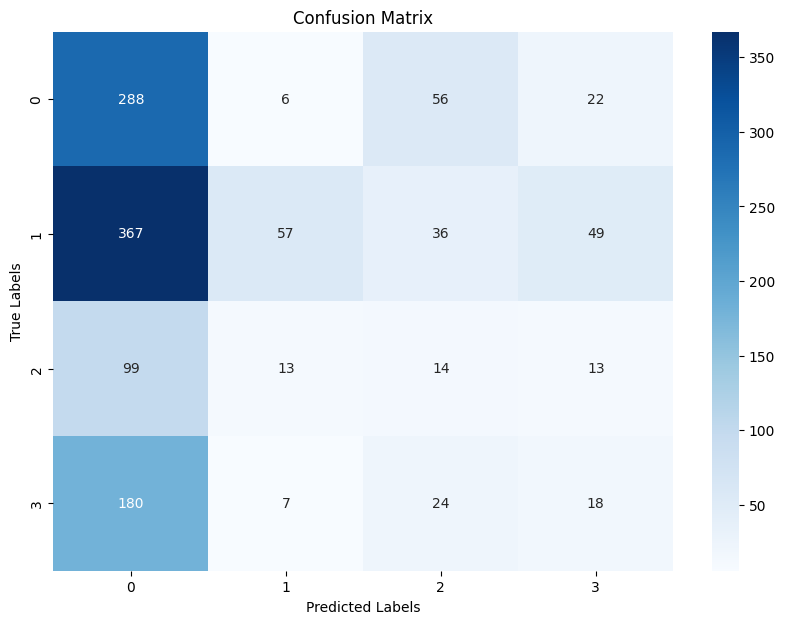

In [57]:
# Plots the confusion matrix
plot_confusion_matrix(vit_1e_3_dropout, test_dataloader, device)

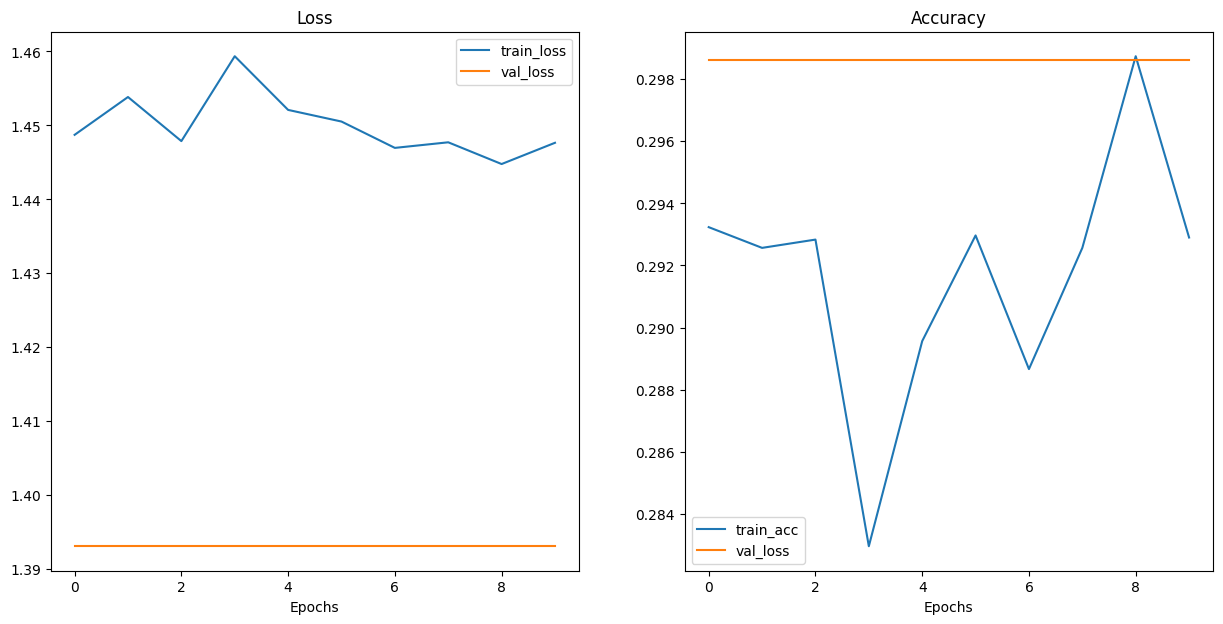

In [58]:
# Plots the loss and accuracy curves
plot_loss_curves(vit_1e_3_dropout_results, "val")

In [59]:
# Save the model
save_model(vit_1e_3_dropout, "models", "vit_1e-3_dropout.pth")

[INFO] Saving model to: models\vit_1e-3_dropout.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


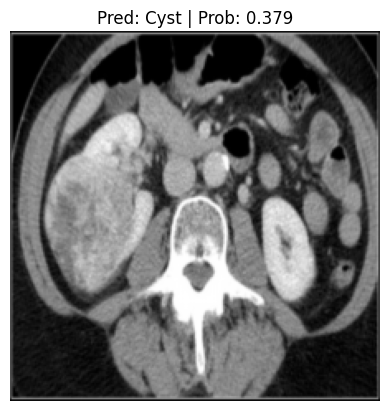

In [60]:
# Custom Image
custom_image_path = data_path / "Tumor1.jpg"
custom_transform = transforms.Compose([
    transforms.Resize((224, 224))
])
pred_and_plot_image(model=vit_1e_3_dropout,
                    image_path=custom_image_path,
                    transform = custom_transform,
                    class_names=class_names)

In [1]:
vit_1e_3_accuracy = "99.60%"
vit_1e_2_accuracy = "96.64%"
vit_1e_4_accuracy = "93.35%"
vit_0_5_accuracy = "95.44%"
vit_freeze_till_4_accuracy = "95.68%"
vit_freeze_till_6_accuracy = "95.68%"
vit_1e_3_dropout_ACCURACY = " 30.18%"

In [3]:
accuracies = [
    ("vit_1e_3_accuracy", 99.60),
    ("vit_1e_2_accuracy", 96.64),
    ("vit_1e_4_accuracy", 93.35),
    ("vit_0_5_accuracy", 95.44),
    ("vit_freeze_till_4_accuracy", 95.68),
    ("vit_freeze_till_6_accuracy", 95.68),
    ("vit_1e_3_dropout_ACCURACY", 30.18)
]
sorted_accuracies = sorted(accuracies, key=lambda x: x[1], reverse=True)
sorted_accuracies

[('vit_1e_3_accuracy', 99.6),
 ('vit_1e_2_accuracy', 96.64),
 ('vit_freeze_till_4_accuracy', 95.68),
 ('vit_freeze_till_6_accuracy', 95.68),
 ('vit_0_5_accuracy', 95.44),
 ('vit_1e_4_accuracy', 93.35),
 ('vit_1e_3_dropout_ACCURACY', 30.18)]

### Case 8 Dropout 0.2

In [44]:
vit_1e_3_dropout_02 = torchvision.models.vit_b_16(weights=vit_weights).to(device)
for parameter in vit_1e_3_dropout_02.parameters():
    parameter.requires_grad=False
set_seed()
vit_1e_3_dropout_02.heads = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(in_features=768,
              out_features=len(class_names)).to(device)
)
summary(model=vit_1e_3_dropout_02,
        input_size=(1, 3, 224, 224), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 4]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [14]:
# Setup optimizer and loss functions
optimizer = torch.optim.Adam(params=vit_1e_3_dropout_02.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

In [45]:
# Train the model
set_seed()
vit_1e_3_dropout_02_results = train(model=vit_1e_3_dropout_02,
                    train_dataloader=train_dataloader,
                    test_dataloader=val_dataloader,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    epochs=10,
                    device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.4021 , Train acc: 0.3071 | Test loss: 1.3931, Test acc: 0.2986
Epoch: 1 | Train loss: 1.4053 , Train acc: 0.3121 | Test loss: 1.3931, Test acc: 0.2986
Epoch: 2 | Train loss: 1.4034 , Train acc: 0.3050 | Test loss: 1.3931, Test acc: 0.2986
Epoch: 3 | Train loss: 1.4072 , Train acc: 0.3038 | Test loss: 1.3931, Test acc: 0.2986
Epoch: 4 | Train loss: 1.4028 , Train acc: 0.3041 | Test loss: 1.3931, Test acc: 0.2986
Epoch: 5 | Train loss: 1.4021 , Train acc: 0.3101 | Test loss: 1.3931, Test acc: 0.2986
Epoch: 6 | Train loss: 1.4033 , Train acc: 0.3072 | Test loss: 1.3931, Test acc: 0.2986
Epoch: 7 | Train loss: 1.4036 , Train acc: 0.3042 | Test loss: 1.3931, Test acc: 0.2986
Epoch: 8 | Train loss: 1.4024 , Train acc: 0.3058 | Test loss: 1.3931, Test acc: 0.2986
Epoch: 9 | Train loss: 1.4016 , Train acc: 0.3062 | Test loss: 1.3931, Test acc: 0.2986


Test Accuracy: 30.18%


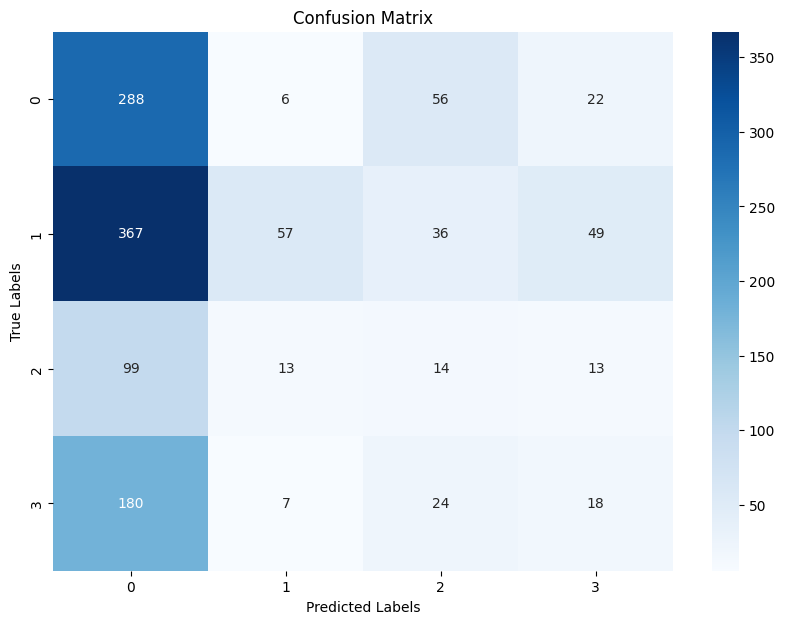

In [46]:
# Plots the confusion matrix
plot_confusion_matrix(vit_1e_3_dropout_02, test_dataloader, device)

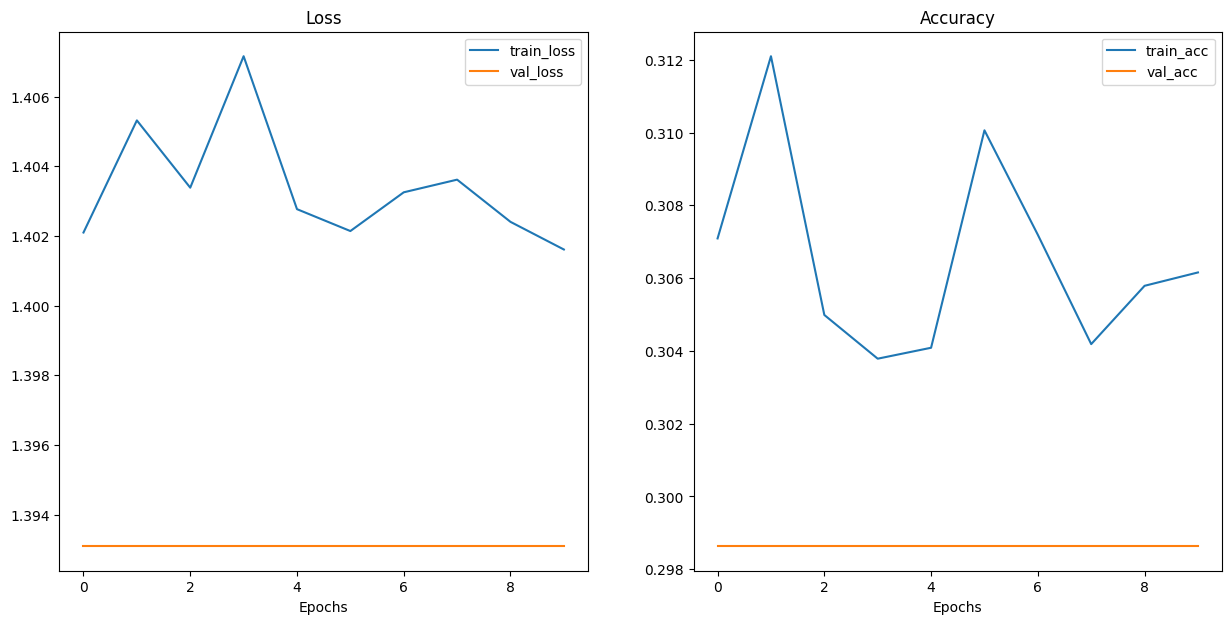

In [47]:
# Plots the loss and accuracy curves
plot_loss_curves(vit_1e_3_dropout_02_results, "val")

In [48]:
# Save the model
save_model(vit_1e_3_dropout_02, "models", "vit_1e-3_dropout_02.pth")

[INFO] Saving model to: models\vit_1e-3_dropout_02.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


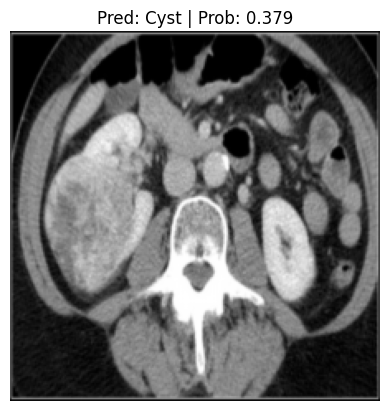

In [49]:
# Custom Image
custom_image_path = data_path / "Tumor1.jpg"
custom_transform = transforms.Compose([
    transforms.Resize((224, 224))
])
pred_and_plot_image(model=vit_1e_3_dropout_02,
                    image_path=custom_image_path,
                    transform = custom_transform,
                    class_names=class_names)

### case 9 Dropout 0.3

In [50]:
vit_1e_3_dropout_03 = torchvision.models.vit_b_16(weights=vit_weights).to(device)
for parameter in vit_1e_3_dropout_03.parameters():
    parameter.requires_grad=False
set_seed()
vit_1e_3_dropout_03.heads = nn.Sequential(
    nn.Dropout(0.3), 
    nn.Linear(in_features=768,
              out_features=len(class_names)).to(device)
)
summary(model=vit_1e_3_dropout_03, 
        input_size=(1, 3, 224, 224), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 4]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [51]:
# Setup optimizer and loss functions
optimizer = torch.optim.Adam(params=vit_1e_3_dropout_03.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

In [52]:
# Train the model
set_seed()
vit_1e_3_dropout_03_results = train(model=vit_1e_3_dropout_03,
                    train_dataloader=train_dataloader,
                    test_dataloader=val_dataloader,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    epochs=10,
                    device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 0.5184 , Train acc: 0.8251 | Test loss: 0.3211, Test acc: 0.9024
Epoch: 1 | Train loss: 0.2849 , Train acc: 0.9086 | Test loss: 0.2246, Test acc: 0.9330
Epoch: 2 | Train loss: 0.2356 , Train acc: 0.9199 | Test loss: 0.1802, Test acc: 0.9470
Epoch: 3 | Train loss: 0.2151 , Train acc: 0.9264 | Test loss: 0.1567, Test acc: 0.9540
Epoch: 4 | Train loss: 0.1915 , Train acc: 0.9356 | Test loss: 0.1395, Test acc: 0.9590
Epoch: 5 | Train loss: 0.1859 , Train acc: 0.9342 | Test loss: 0.1281, Test acc: 0.9698
Epoch: 6 | Train loss: 0.1750 , Train acc: 0.9388 | Test loss: 0.1195, Test acc: 0.9672
Epoch: 7 | Train loss: 0.1764 , Train acc: 0.9385 | Test loss: 0.1108, Test acc: 0.9662
Epoch: 8 | Train loss: 0.1697 , Train acc: 0.9386 | Test loss: 0.1011, Test acc: 0.9678
Epoch: 9 | Train loss: 0.1540 , Train acc: 0.9475 | Test loss: 0.0963, Test acc: 0.9698


Test Accuracy: 97.92%


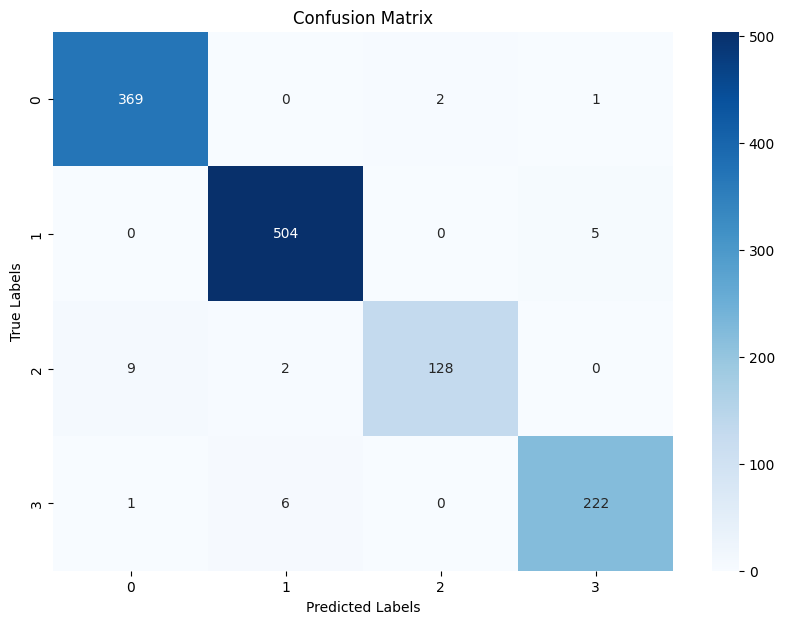

In [53]:
# Plots the confusion matrix
plot_confusion_matrix(vit_1e_3_dropout_03, test_dataloader, device)

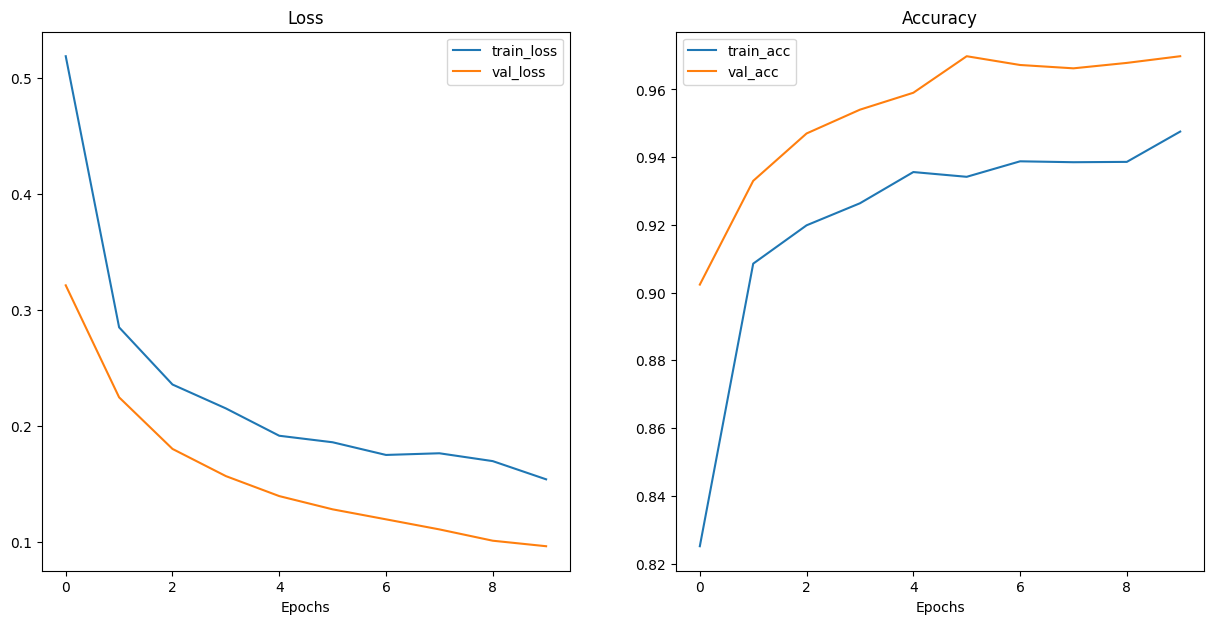

In [54]:
# Plots the loss and accuracy curves
plot_loss_curves(vit_1e_3_dropout_03_results, "val")

In [55]:
# Save the model
save_model(vit_1e_3_dropout_03, "models", "vit_1e-3_dropout_03.pth")

[INFO] Saving model to: models\vit_1e-3_dropout_03.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


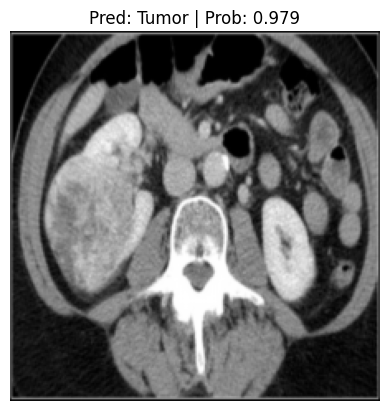

In [56]:
# Custom Image
custom_image_path = data_path / "Tumor1.jpg"
custom_transform = transforms.Compose([
    transforms.Resize((224, 224))
])
pred_and_plot_image(model=vit_1e_3_dropout_03,
                    image_path=custom_image_path,
                    transform = custom_transform,
                    class_names=class_names)

## VGG

In [57]:
vgg_weights = torchvision.models.VGG19_Weights.DEFAULT
vgg_transforms = vgg_weights.transforms()
BATCH_SIZE =32

# Image folders
vgg_train_data = datasets.ImageFolder(root= train_dir, 
                                transform= vit_transforms)
vgg_test_data = datasets.ImageFolder(root=test_dir, 
                                transform=vit_transforms)
vgg_val_data = datasets.ImageFolder(root=val_dir, 
                                transform=vit_transforms)
# Data Loaders
vgg_train_dataloader = DataLoader(dataset=vgg_train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)
vgg_test_dataloader = DataLoader(dataset=vgg_test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=False)
vgg_val_dataloader = DataLoader(dataset=vgg_val_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=False)

In [58]:
vgg_1e_3 = torchvision.models.vgg19(weights=vgg_weights).to(device)
for parameter in vgg_1e_3.parameters():
    parameter.requires_grad=False
set_seed()
vgg_1e_3.classifier[6] = torch.nn.Linear(in_features=vgg_1e_3.classifier[6].in_features, out_features=len(class_names)).to(device)
for parameter in vgg_1e_3.classifier[6].parameters():
    parameter.requires_grad=True
summary(model=vgg_1e_3,
        input_size=(1, 3, 224, 224), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VGG (VGG)                                [1, 3, 224, 224]     [1, 4]               --                   Partial
├─Sequential (features)                  [1, 3, 224, 224]     [1, 512, 7, 7]       --                   False
│    └─Conv2d (0)                        [1, 3, 224, 224]     [1, 64, 224, 224]    (1,792)              False
│    └─ReLU (1)                          [1, 64, 224, 224]    [1, 64, 224, 224]    --                   --
│    └─Conv2d (2)                        [1, 64, 224, 224]    [1, 64, 224, 224]    (36,928)             False
│    └─ReLU (3)                          [1, 64, 224, 224]    [1, 64, 224, 224]    --                   --
│    └─MaxPool2d (4)                     [1, 64, 224, 224]    [1, 64, 112, 112]    --                   --
│    └─Conv2d (5)                        [1, 64, 112, 112]    [1, 128, 112, 112]   (73,856)             False
│    └─ReLU (

In [59]:
# Setup optimizer and loss functions
optimizer = torch.optim.Adam(params=vgg_1e_3.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

In [60]:
# Train the model
set_seed()
vgg_1e_3_results = train(model=vgg_1e_3,
                    train_dataloader=vgg_train_dataloader,
                    test_dataloader=vgg_val_dataloader,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    epochs=10,
                    device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 0.6622 , Train acc: 0.7435 | Test loss: 0.4135, Test acc: 0.8637
Epoch: 1 | Train loss: 0.4939 , Train acc: 0.8113 | Test loss: 0.3016, Test acc: 0.9117
Epoch: 2 | Train loss: 0.4497 , Train acc: 0.8344 | Test loss: 0.2507, Test acc: 0.9255
Epoch: 3 | Train loss: 0.4498 , Train acc: 0.8307 | Test loss: 0.2306, Test acc: 0.9387
Epoch: 4 | Train loss: 0.4304 , Train acc: 0.8415 | Test loss: 0.2415, Test acc: 0.9178
Epoch: 5 | Train loss: 0.4246 , Train acc: 0.8433 | Test loss: 0.2101, Test acc: 0.9397
Epoch: 6 | Train loss: 0.4090 , Train acc: 0.8484 | Test loss: 0.2081, Test acc: 0.9397
Epoch: 7 | Train loss: 0.4175 , Train acc: 0.8444 | Test loss: 0.1843, Test acc: 0.9469
Epoch: 8 | Train loss: 0.4143 , Train acc: 0.8466 | Test loss: 0.1811, Test acc: 0.9434
Epoch: 9 | Train loss: 0.4151 , Train acc: 0.8516 | Test loss: 0.1660, Test acc: 0.9533


Test Accuracy: 94.64%


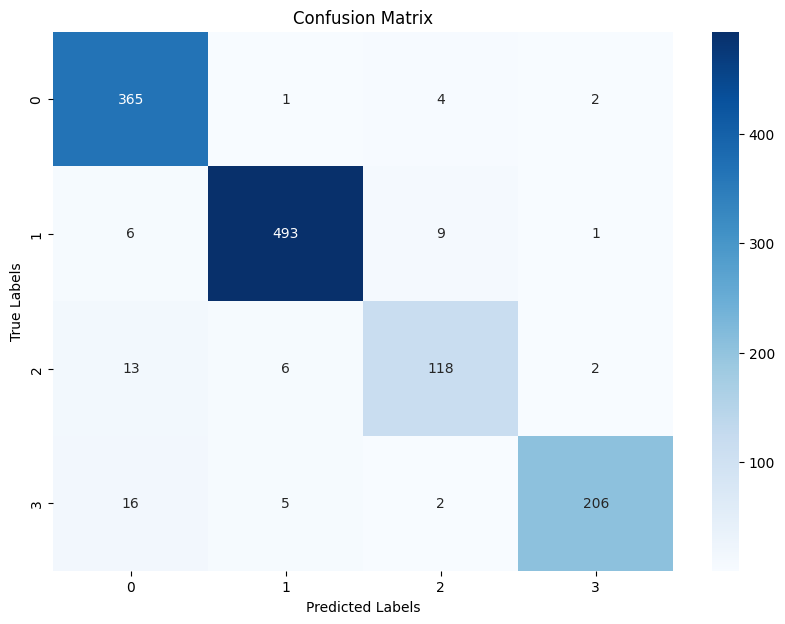

In [61]:
# Plots the confusion matrix
plot_confusion_matrix(vgg_1e_3, vgg_test_dataloader, device)

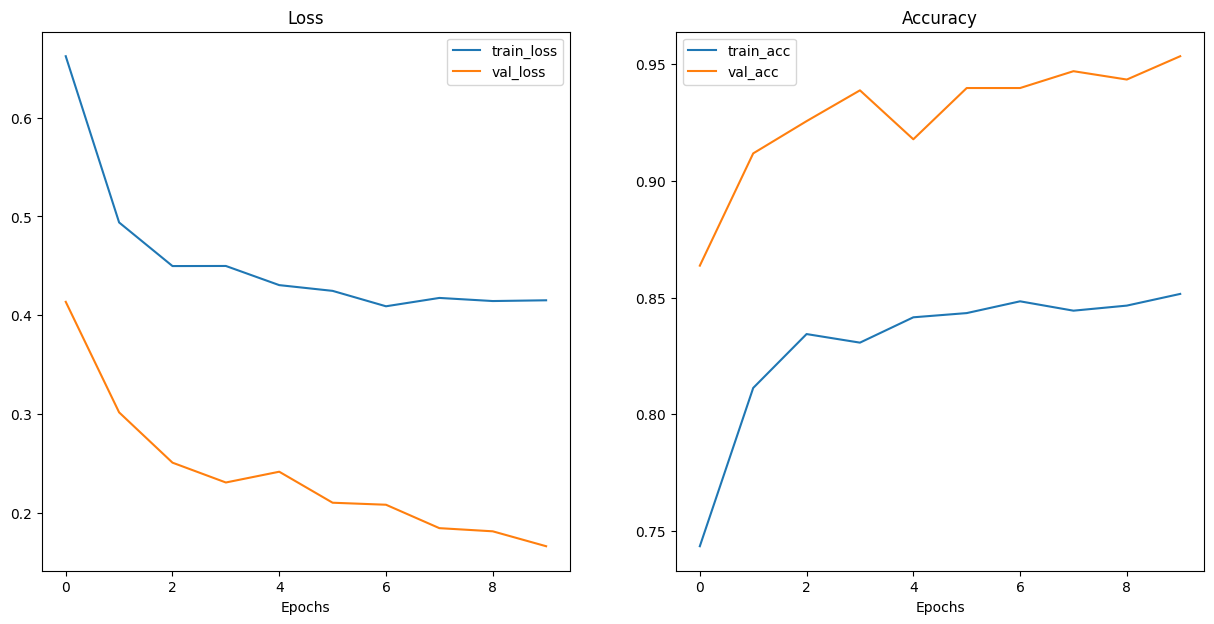

In [62]:
# Plots the loss and accuracy curves
plot_loss_curves(vgg_1e_3_results, "val")

In [63]:
# Save the model
save_model(vgg_1e_3, "models", "vgg_1e-3.pth")

[INFO] Saving model to: models\vgg_1e-3.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


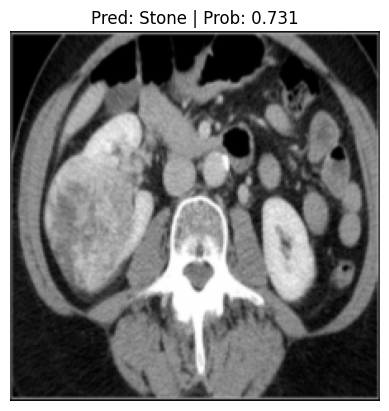

In [64]:
# Custom Image
custom_image_path = data_path / "Tumor1.jpg"
custom_transform = transforms.Compose([
    transforms.Resize((224, 224))
])
pred_and_plot_image(model=vgg_1e_3,
                    image_path=custom_image_path,
                    transform = custom_transform,
                    class_names=class_names)

### RESNET

In [65]:
resnet_weights = torchvision.models.ResNet50_Weights.DEFAULT
resnet_transforms = resnet_weights.transforms()
BATCH_SIZE =32

# Image folders
resnet_train_data = datasets.ImageFolder(root= train_dir, 
                                transform= resnet_transforms)
resnet_test_data = datasets.ImageFolder(root=test_dir, 
                                transform=resnet_transforms)
resnet_val_data = datasets.ImageFolder(root=val_dir, 
                                transform=resnet_transforms)
# Data Loaders
resnet_train_dataloader = DataLoader(dataset=resnet_train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)
resnet_test_dataloader = DataLoader(dataset=resnet_test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=False)
resnet_val_dataloader = DataLoader(dataset=resnet_val_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=False)

In [66]:
resnet_1e_3 = torchvision.models.resnet50(weights=resnet_weights).to(device)
for parameter in resnet_1e_3.parameters():
    parameter.requires_grad=False
    
resnet_1e_3.fc = torch.nn.Linear(in_features=resnet_1e_3.fc.in_features, out_features=len(class_names)).to(device)

for parameter in resnet_1e_3.fc.parameters():
    parameter.requires_grad=True
    
summary(model=resnet_1e_3,
        input_size=(1, 3, 224, 224), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [1, 3, 224, 224]     [1, 4]               --                   Partial
├─Conv2d (conv1)                         [1, 3, 224, 224]     [1, 64, 112, 112]    (9,408)              False
├─BatchNorm2d (bn1)                      [1, 64, 112, 112]    [1, 64, 112, 112]    (128)                False
├─ReLU (relu)                            [1, 64, 112, 112]    [1, 64, 112, 112]    --                   --
├─MaxPool2d (maxpool)                    [1, 64, 112, 112]    [1, 64, 56, 56]      --                   --
├─Sequential (layer1)                    [1, 64, 56, 56]      [1, 256, 56, 56]     --                   False
│    └─Bottleneck (0)                    [1, 64, 56, 56]      [1, 256, 56, 56]     --                   False
│    │    └─Conv2d (conv1)               [1, 64, 56, 56]      [1, 64, 56, 56]      (4,096)              False
│    │    

In [67]:
# Setup optimizer and loss functions
optimizer = torch.optim.Adam(params=resnet_1e_3.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

In [68]:
# Train the model
set_seed()
resnet_1e_3_results = train(model=resnet_1e_3,
                    train_dataloader=train_dataloader,
                    test_dataloader=val_dataloader,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    epochs=10,
                    device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 0.6779 , Train acc: 0.7830 | Test loss: 0.4459, Test acc: 0.9065
Epoch: 1 | Train loss: 0.3610 , Train acc: 0.9044 | Test loss: 0.3097, Test acc: 0.9229
Epoch: 2 | Train loss: 0.2560 , Train acc: 0.9415 | Test loss: 0.2222, Test acc: 0.9638
Epoch: 3 | Train loss: 0.2064 , Train acc: 0.9544 | Test loss: 0.1937, Test acc: 0.9598
Epoch: 4 | Train loss: 0.1681 , Train acc: 0.9671 | Test loss: 0.1538, Test acc: 0.9760
Epoch: 5 | Train loss: 0.1465 , Train acc: 0.9699 | Test loss: 0.1290, Test acc: 0.9808
Epoch: 6 | Train loss: 0.1233 , Train acc: 0.9774 | Test loss: 0.1146, Test acc: 0.9880
Epoch: 7 | Train loss: 0.1112 , Train acc: 0.9780 | Test loss: 0.1067, Test acc: 0.9760
Epoch: 8 | Train loss: 0.0974 , Train acc: 0.9828 | Test loss: 0.0950, Test acc: 0.9824
Epoch: 9 | Train loss: 0.0877 , Train acc: 0.9837 | Test loss: 0.0847, Test acc: 0.9904


Test Accuracy: 98.48%


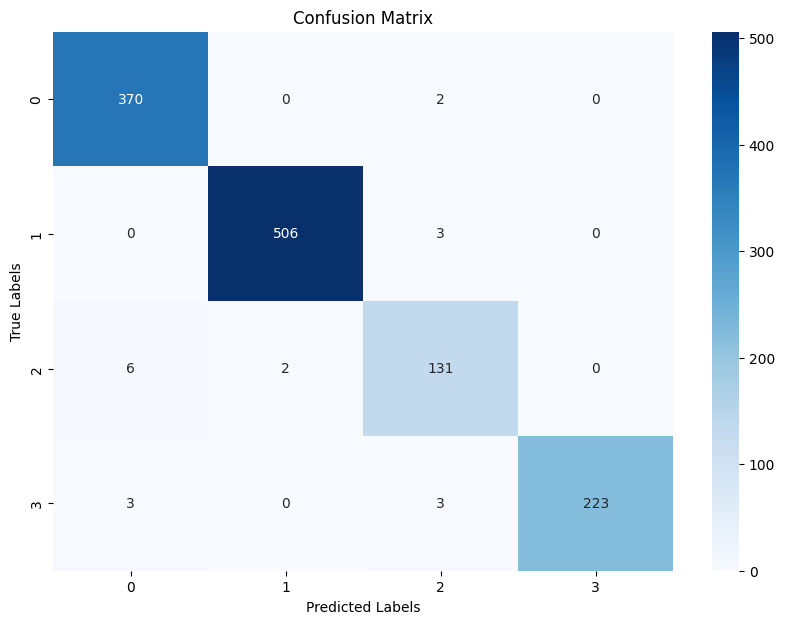

In [69]:
# Plots the confusion matrix
plot_confusion_matrix(resnet_1e_3, test_dataloader, device)

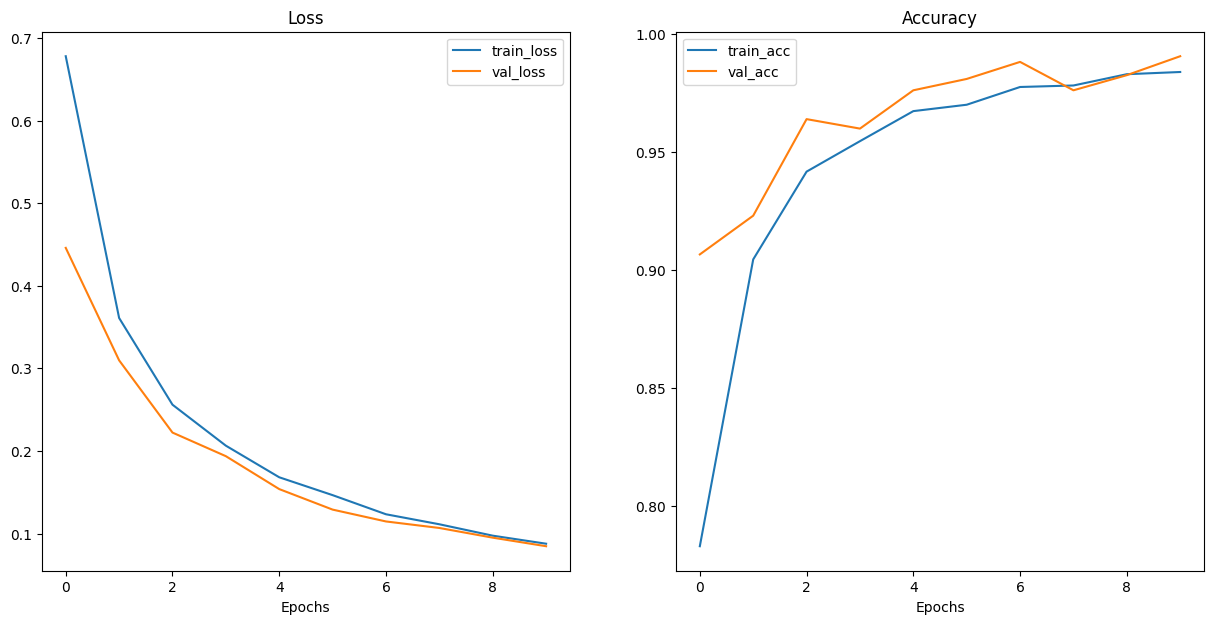

In [70]:
# Plots the loss and accuracy curves
plot_loss_curves(resnet_1e_3_results, "val")

In [71]:
# Save the model
save_model(resnet_1e_3, "models", "resnet_1e-3.pth")

[INFO] Saving model to: models\resnet_1e-3.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


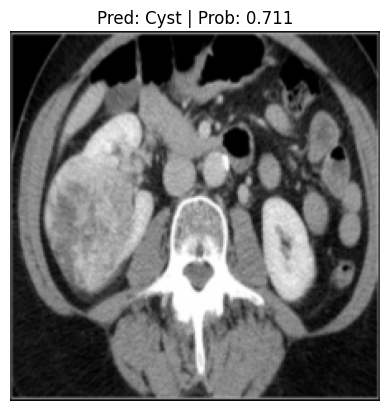

In [73]:
# Custom Image
custom_image_path = data_path / "Tumor1.jpg"
custom_transform = transforms.Compose([
    transforms.Resize((224, 224))
])
pred_and_plot_image(model=resnet_1e_3,
                    image_path=custom_image_path,
                    transform = custom_transform,
                    class_names=class_names)